# Writing a VCell simulation dataset to Zarr

In [3]:
import os
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
import zarr
from vcelldata.mesh import CartesianMesh
from vcelldata.postprocessing import PostProcessing
from vcelldata.simdata_models import PdeDataSet, DataFunctions
from vcelldata.zarr_writer import write_zarr

## run the vcell simulation

In [4]:
test_data_dir = Path(os.getcwd()) / "test_data"
fv_input_file = test_data_dir / "SimID_946368938_0_.fvinput"
vcg_file = test_data_dir / "SimID_946368938_0_.vcg"
functions_file = test_data_dir / "SimID_946368938_0_.functions"
test_output_dir = Path(os.getcwd()) / "test_output"

from pyvcell_fvsolver import solve
import shutil

for file in test_output_dir.iterdir() if test_output_dir.exists() else []:
    file.unlink()
    
shutil.copy(functions_file, test_output_dir)

print("can only run once right now, then restart the kernel, else it dumps ...")

ret_code: int = solve(str(fv_input_file), str(vcg_file), str(test_output_dir))
assert ret_code == 0, "solve failed"


can only run once right now, then restart the kernel, else it dumps ...
initializing mesh


Simulation Complete in Main() ... 


numVolume=126025

CartesianMesh::computeNormalsFromNeighbors(), compute normals from neighbors
Membrane Elements -> N=7817
--------Num of points that have zero neighbors 0
--------Num Neighbors before symmetrize 46161
--------Num Neighbors after symmetrize 51016
Total volume=5824.650822
Total FluxArea =36.79383373
Total FluxAreaXM =0
Total FluxAreaXP =0
Total FluxAreaYM =21.43445916
Total FluxAreaYP =15.35937457
Total FluxAreaZM =0
Total FluxAreaZP =0
mesh initialized
preprocessing finished
pdeCount=4, odeCount=0
error opening log file </Users/jimschaff/Documents/workspace/vcell/pythonData/test_output/SimID_946368938_0_.log>
simulation [SimID_946368938_0_] started
temporary directory used is /var/folders/zz/gcfcvgtd5v1cdgj2sw4bjzdr0000gr/T/
sim file name is /var/folders/zz/gcfcvgtd5v1cdgj2sw4bjzdr0000gr/T/SimID_946368938_0_0000.sim
**This is a little endian machine.**
[[[data:0]]]
numVolRegions=6
Region 0: size=110800, offset=0
Region 1: size=12207, offset=110800
Region 2: size=1, offs

## read vcell simulation results metadata
* `PdeDataSet` contains the metadata for the tabular simulation results (e.g. state variables, shape, time points)
* `DataFunctions` contains the function definitions (name, expression, type, domain)
![vcell simulation results](./example_vcell_ui.png)

In [5]:
sim_id = 946368938
job_id = 0
pde_dataset = PdeDataSet(base_dir=test_output_dir, log_filename=f"SimID_{sim_id}_{job_id}_.log")
pde_dataset.read()
data_functions = DataFunctions(function_file=test_output_dir / f"SimID_{sim_id}_{job_id}_.functions")
data_functions.read()
mesh = CartesianMesh(mesh_file=test_output_dir / f"SimID_{sim_id}_{job_id}_.mesh")
mesh.read()
post_processing = PostProcessing(postprocessing_hdf5_path=test_output_dir / f"SimID_{sim_id}_{job_id}_.hdf5")
post_processing.read()

## write the vcell simulation dataset to zarr including:
* metadata
* numerical datasets from stored data and evaluated functions
* ... masks for domains coming soon (e.g. cell, extracellular, etc.)

In [6]:
write_zarr(pde_dataset=pde_dataset, data_functions=data_functions, mesh=mesh, zarr_dir=test_output_dir / "zarr")

## Open and display slices from the zarr dataset as an image
* no masking for domains
* different colormap and scaling

In [7]:
# Open the Zarr dataset
dataset = zarr.open(test_output_dir / "zarr", mode='r')
metadata = dataset.attrs.asdict()['metadata']
display(f"shape = {dataset.shape}")
display(metadata)

'shape = (5, 6, 25, 71, 71)'

{'axes': [{'name': 't', 'type': 'time', 'unit': 'second'},
  {'name': 'c', 'type': 'channel', 'unit': None},
  {'name': 'z', 'type': 'space', 'unit': 'micrometer'},
  {'name': 'y', 'type': 'space', 'unit': 'micrometer'},
  {'name': 'x', 'type': 'space', 'unit': 'micrometer'}],
 'channels': [{'domain_name': 'all',
   'index': 0,
   'label': 'region_mask',
   'max_value': 5,
   'min_value': 0},
  {'domain_name': 'cytosol',
   'index': 1,
   'label': 'C_cyt',
   'max_values': [0.0,
    1.6578610924672006e-05,
    3.688810687510523e-05,
    5.838639127450773e-05,
    7.973301033949104e-05],
   'mean_values': [0.0,
    1.6685364276130217e-07,
    5.378445086999078e-07,
    1.013171081901765e-06,
    1.5375380777582898e-06],
   'min_values': [0.0, 0.0, 0.0, 0.0, 0.0]},
  {'domain_name': 'cytosol',
   'index': 2,
   'label': 'Ran_cyt',
   'max_values': [0.0,
    1.6578610924672006e-05,
    3.688810687510523e-05,
    5.838639127450773e-05,
    7.973301033949104e-05],
   'mean_values': [0.0,
  

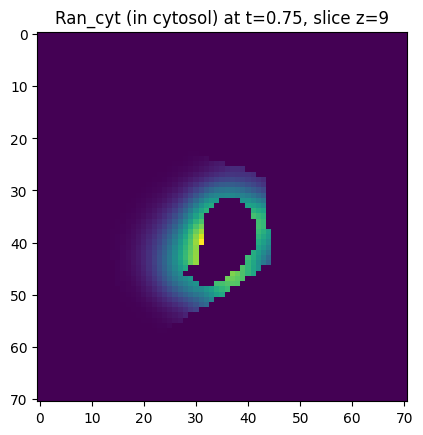

In [8]:
# Get a slice of the dataset, shape is (time, channel, z, y, x)
channel_index = 2
z_index = 9
time_index = 3
slice = dataset[time_index, channel_index, z_index, :, :]
channel_label = metadata['channels'][channel_index]['label']
channel_domain = metadata['channels'][channel_index]['domain_name']
t = metadata['times'][time_index]
title = f"{channel_label} (in {channel_domain}) at t={t}, slice z={z_index}"

# Display the slice as an image
plt.imshow(slice)
plt.title(title)
plt.show()

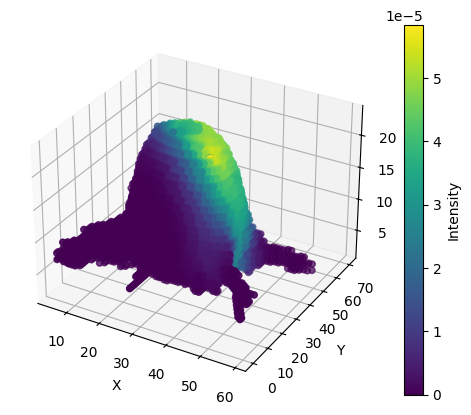

In [9]:
import numpy as np

# Select a 3D volume for a single time point and channel, shape is (z, y, x)
channel_index = 2
time_index = 3
channel_domain = metadata['channels'][channel_index]['domain_name']
volume = dataset[time_index, channel_index, :, :, :]

# Create a figure for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a mask to display the volume (use 'region_mask' channel)
mask = np.copy(dataset[3, 0, :, :, :])
z, y, x = np.where(mask == 1)

# Get the intensity values for these points
intensities = volume[z, y, x]

# Create a 3D scatter plot
scatter = ax.scatter(x, y, z, c=intensities, cmap='viridis')

# Add a color bar to represent intensities
fig.colorbar(scatter, ax=ax, label='Intensity')

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

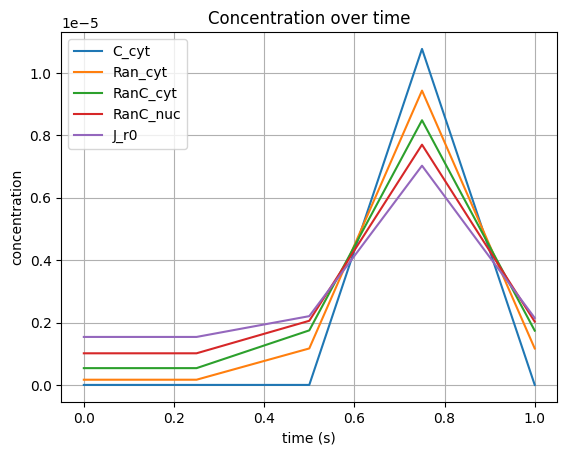

In [10]:
t = metadata['times']
y = [c['mean_values'] for c in metadata['channels'] if c['index'] > 0]
y_labels = [c['label'] for c in metadata['channels'] if c['index'] > 0]

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel='time (s)', ylabel='concentration',
       title='Concentration over time')
ax.legend(y_labels)
ax.grid()


## Open and display slices from the post processing dataset as an image

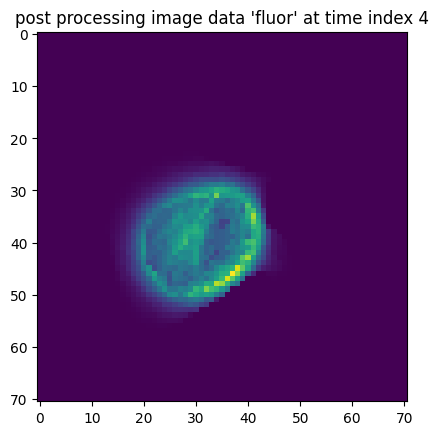

In [11]:
# display image dataset "fluor" at time index 4 as an image
fluorescence = post_processing.image_metadata[0]
image_data: np.ndarray = post_processing.read_image_data(image_metadata=fluorescence, time_index=4)
plt.imshow(image_data)
plt.title("post processing image data 'fluor' at time index 4")
plt.show()

## Open and display Variable Statistics from the post processing dataset

list

vcelldata.postprocessing.VariableInfo

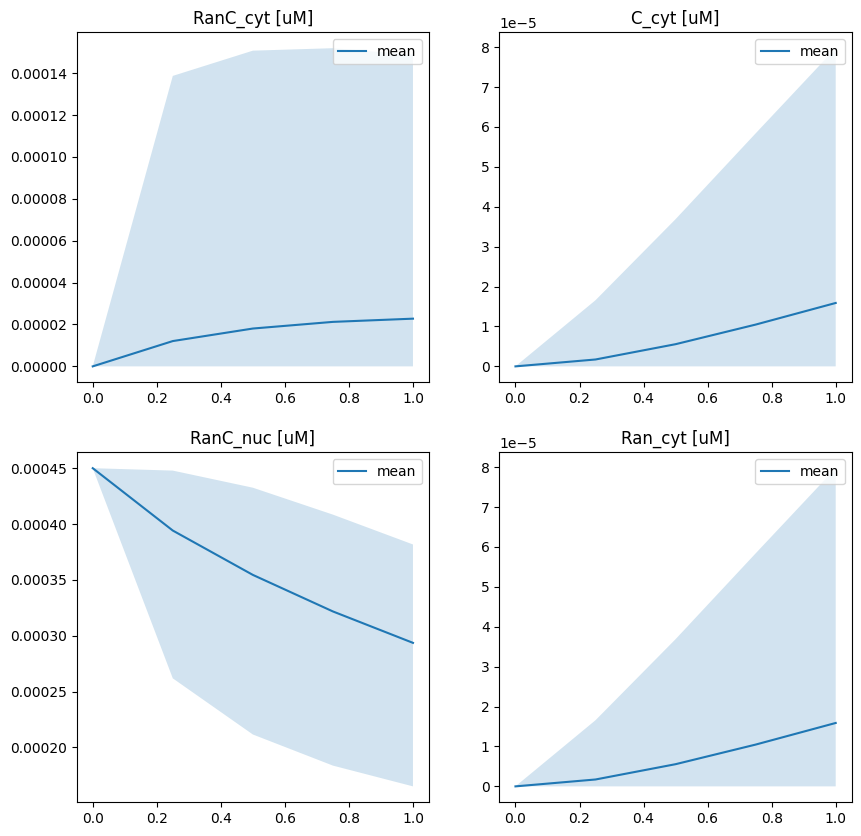

In [12]:

var_averages = list(set([var for var in post_processing.variables if var.statistic_type == 0]))
display(type(var_averages))
display(type(var_averages[0]))
series_arrays = []
series_legend = []
times = post_processing.times
# add envelope plot for each variable
for var_average in var_averages:
    series_arrays.append(post_processing.statistics[:,var_average.var_index,[0,2,3]])
    series_legend.append(f"{var_average.var_name} [{var_average.stat_var_unit}]")

# each series_array has 3 columns: mean, min, max
# plot each series on a different plot arranged in a 2x2 grid with a legend from series_legends
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, series_array in enumerate(series_arrays):
    ax[int(i/2), i%2].plot(times, series_array[:,0], label='mean')
    ax[int(i/2), i%2].fill_between(times, series_array[:,1], series_array[:,2], alpha=0.2)
    ax[int(i/2), i%2].set_title(series_legend[i])
    ax[int(i/2), i%2].legend()

## Open mesh as VTK file

In [13]:
from vcelldata.vtk.fv_mesh_mapping import from_mesh3d_membrane, from_mesh3d_volume
from vcelldata.vtk.vtkmesh_utils import getVolumeVtkGrid, smoothUnstructuredGridSurface

plasma_membrane_region_ids = {0, 1, 2, 3}
plasma_membrane_vismesh = from_mesh3d_membrane(mesh, plasma_membrane_region_ids)
assert plasma_membrane_vismesh.dimension == 3

cytosol_vismesh = from_mesh3d_volume(mesh, "cytosol")
assert cytosol_vismesh.dimension == 3

cytosol_vtu = getVolumeVtkGrid(cytosol_vismesh)
cytosol_vtu = smoothUnstructuredGridSurface(cytosol_vtu)

plasma_membrane_vtu = getVolumeVtkGrid(plasma_membrane_vismesh)
plasma_membrane_vtu = smoothUnstructuredGridSurface(plasma_membrane_vtu)

## Display the mesh in 3D

/Users/jimschaff/Documents/workspace/vcell/pythonData/.venv/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/jimschaff/Documents/workspace/vcell/pythonData/.venv/lib/python3.12/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


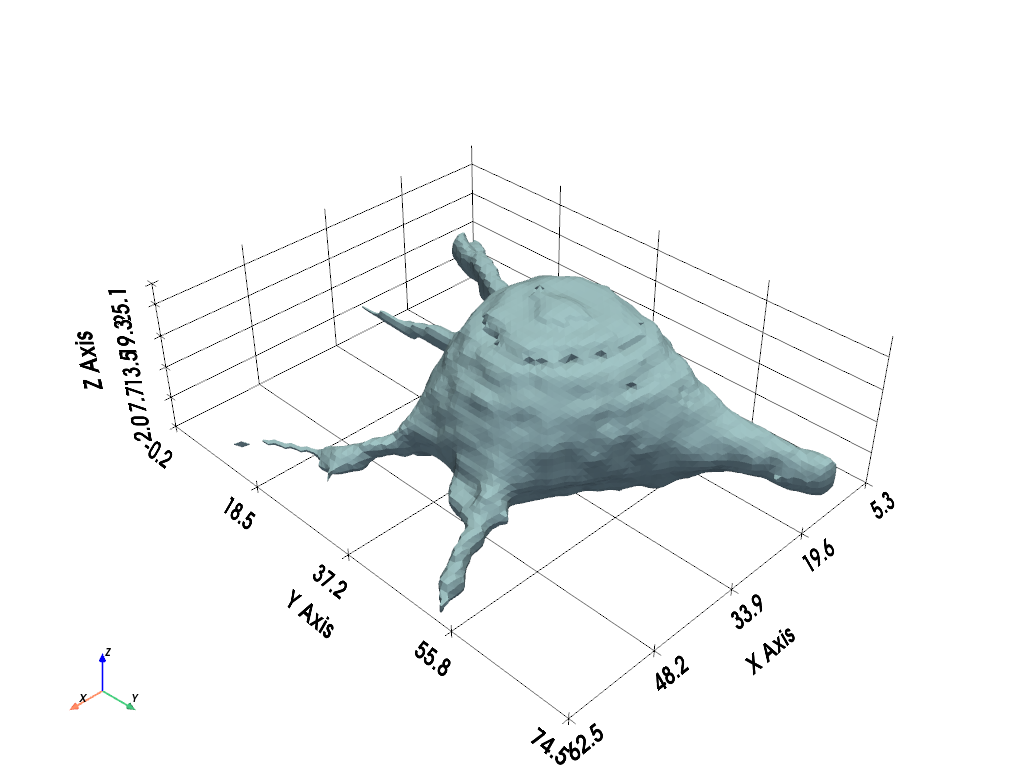

In [14]:
import pyvista as pv

grid = pv.wrap(cytosol_vtu)
grid.plot(notebook=True, show_grid=True, show_axes=True)